<a href="https://colab.research.google.com/github/MaYangle/Basic-Deep-learning/blob/number_detection/number_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **手写数字识别器--认识卷积神经网络**

当我们熟悉了神经网络如何解决预测与分类问题这些基础知识以后，便可以开始学习第一个真正意义上的深度网络了，这就是卷积神经网络(convolutional neural network，CNN)。

以卷积神经网络作为基础架构，我们不仅可以解决图像分类这样的传统问题，而且可以让计算机对图像进行一定程度的理解，这极大地推动了人工智能的发展。比如图像的语义分割(semantic segmentation)，目的是确定一张图片中的不同实体，再划分不同实体之间的边界，并给各个实体加以标注。一些有趣的应用还可以让机器看图说话(image captioning)——通过卷积神经网络将图像处理成一个隐含向量的编码，再用循环神经网络解读这段编码。

卷积神经网络之所以突然获得如此成功，是因为它能够自动从数据中提取特征。在此之前的网络结构都依赖设计人员的精力和经验。卷积神经网络的突破在与它可以将整个特征工程自动化：无须实验人员的参与，就能自动从数据中学习出识别模板。


**本文将围绕手写数字识别这一内容，介绍卷积神经网络的工作原理。会使用pytorch来实现一个卷积神经网络，完成手写数字识别任务。在此基础上，引出过滤器、特征匹配与特征图的概念，揭示卷积神经网络的工作原理。**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1.什么是卷积神经网络**

首先，从直观上认识一下卷积神经网络，如下图：

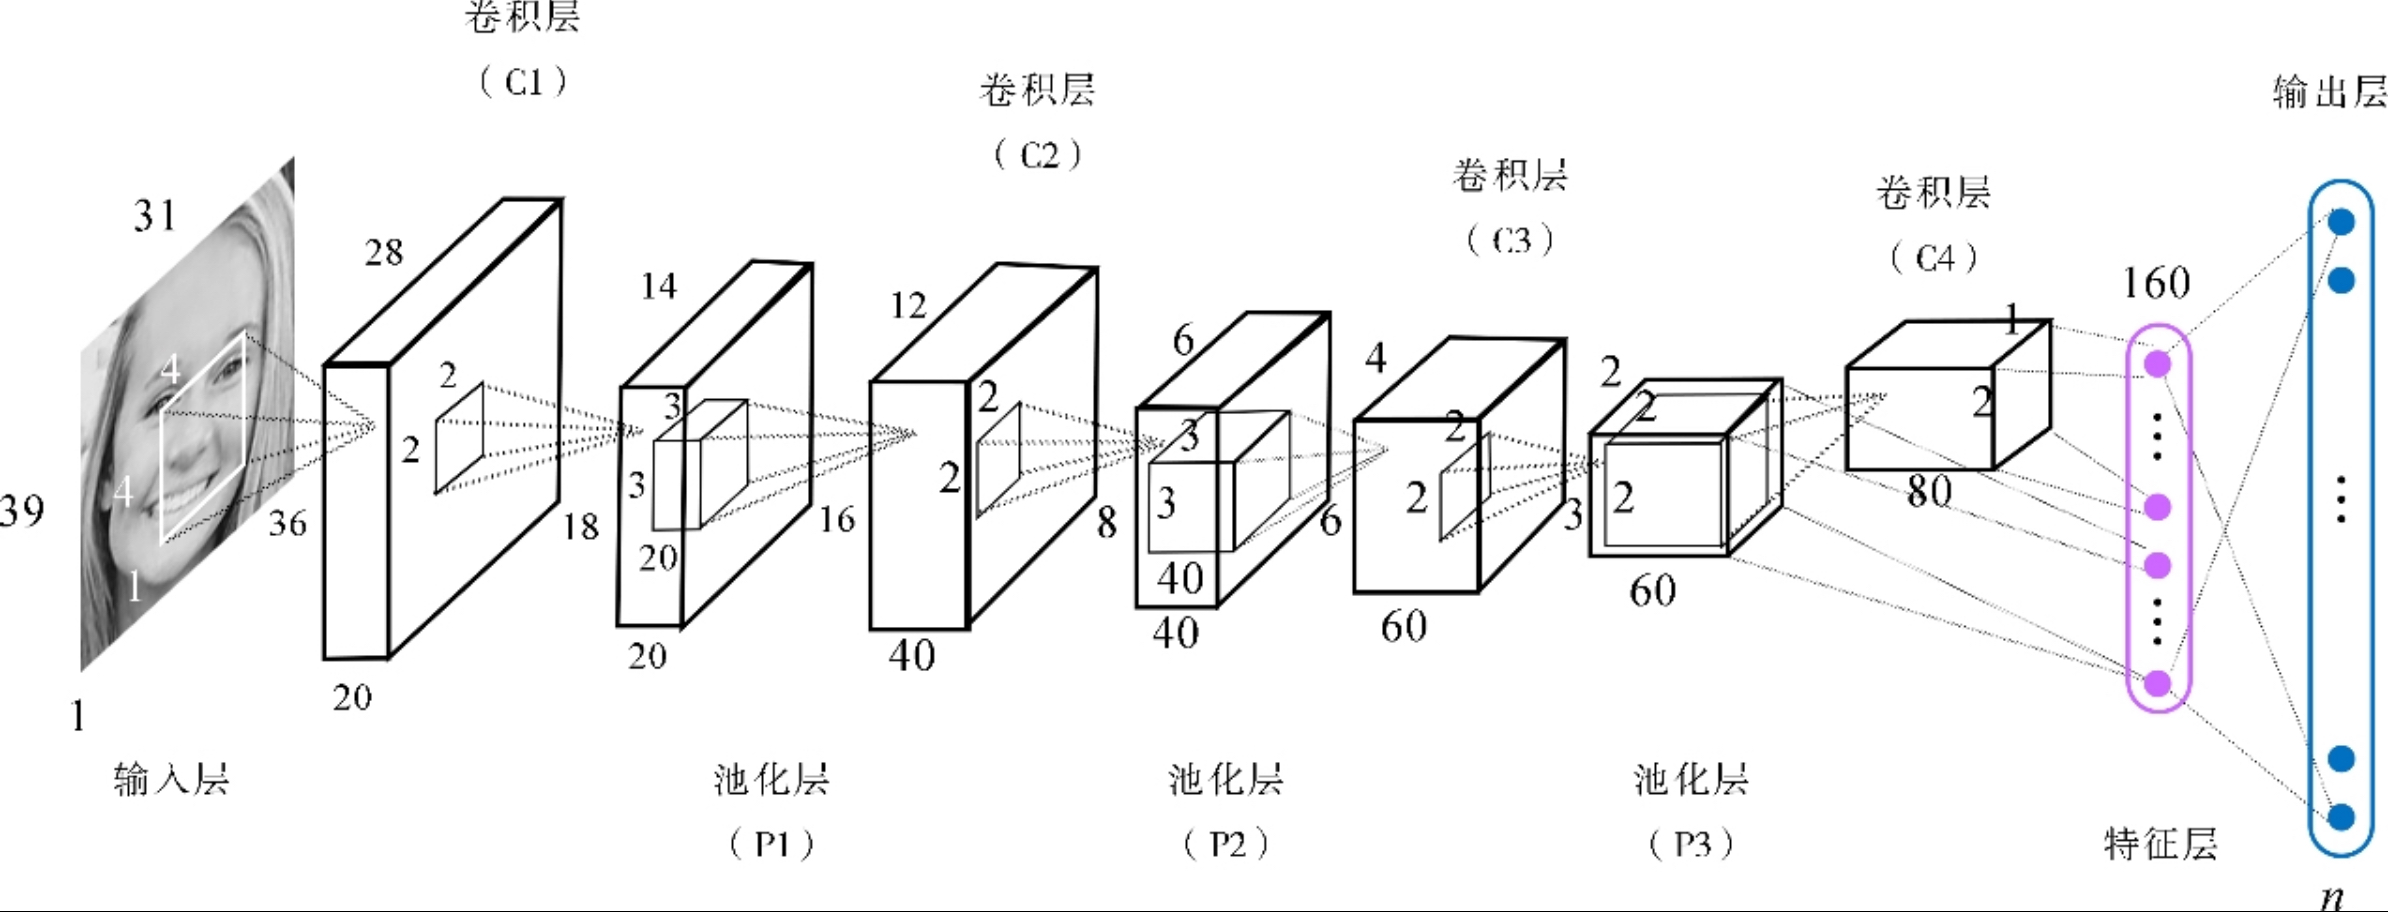

In [ ]:
photo_paths = []
for i in range(1, 10):
    photo_paths.append("/content/drive/MyDrive/Colab Notebooks/convolutional neural network/{}.jpg".format(i))

from IPython.display import Image
Image(filename=photo_path1)

可以看到，卷积神经网络由若干个方块盒子构成，盒子从左到右仿佛越来越小，但越来越厚；最左边是一张图像，最右边则变成了两排圆圈。其实每一个方块都是由大量神经元构成的，只不过它们排成了立方体的形状。

**左边图象上的每个元素相当于一个神经元，构成了这个卷积神经网络的输入单元。**最右侧的圆圈也是神经元，它们排列成了两条直线，构成了该网络的输出。

卷积神经网络其实也是一种前馈神经网络，承载了深层的信息处理过程。信息从左侧输入，经过层层加工处理，最后从右侧输出。**对于图像分类任务而言，输入的是一张图像，历经一系列卷积层、池化层和完全连接层的运算，最终输出一组分类的概率，要分成多少类别，就有多少个输出神经元。**

相邻两层的神经元连接用上图中的小立体锥近似表示，实际上这种锥形遍布更高一层（右侧）立方体中的所有神经元。

**低层（左侧）到高层（右侧）的运算主要分为两大类：卷积和池化。一层卷积，一层池化，这两种运算交替进行，直到最后一层，我们又把立方体中的神经元拉平成了线性排列的神经元，与最后的输出层进行全连接。**

### **1.1手写数字识别任务的卷积神经网络及运算过程**

以手写数字识别任务为例来进一步认识卷积神经网络，该任务的输入是一张28X28的灰度图像，如下图所示。图中包含一个手写的数字，输出就是卷积神经网络识别出来的数字。

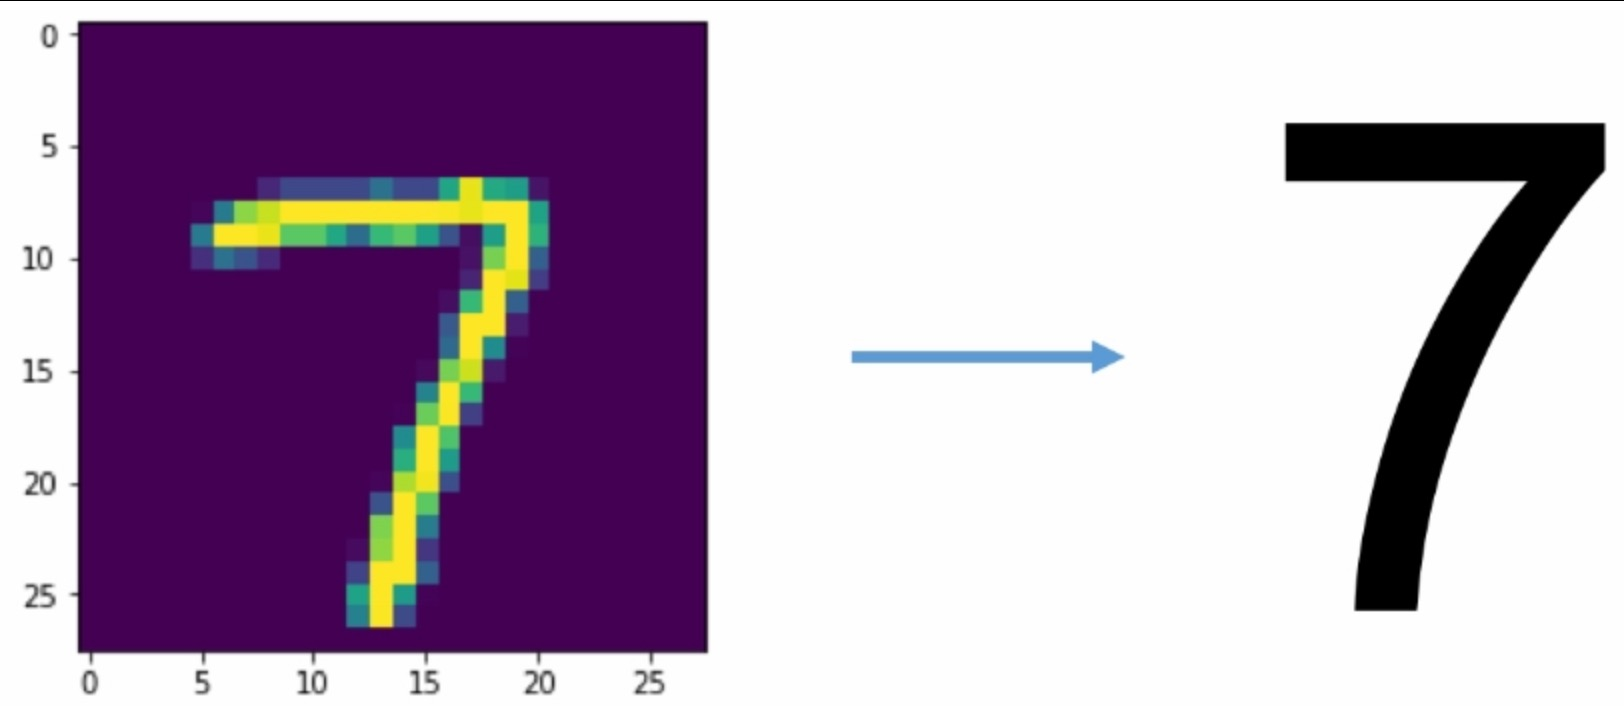

In [ ]:
Image(filename=photo_path2,width=1100,height=500)

计算机中，输入的图像被表示成了一个尺寸为（28,28）的张量，其中张量的任意一个元素都是一个0-255的数字，表示该像素点的灰度值，越接近255，这个点就会白。这些输入像素点自然构成了卷积神经网络的输入神经元，因此，输入神经元排布成一个正方形。

为完成这个手写数字识别任务，设计了如下图所示架构的卷积神经网络**（在具体的设计网络架构时，网络的层数，每一层的神经元，都可以作为超参数重新选择）**

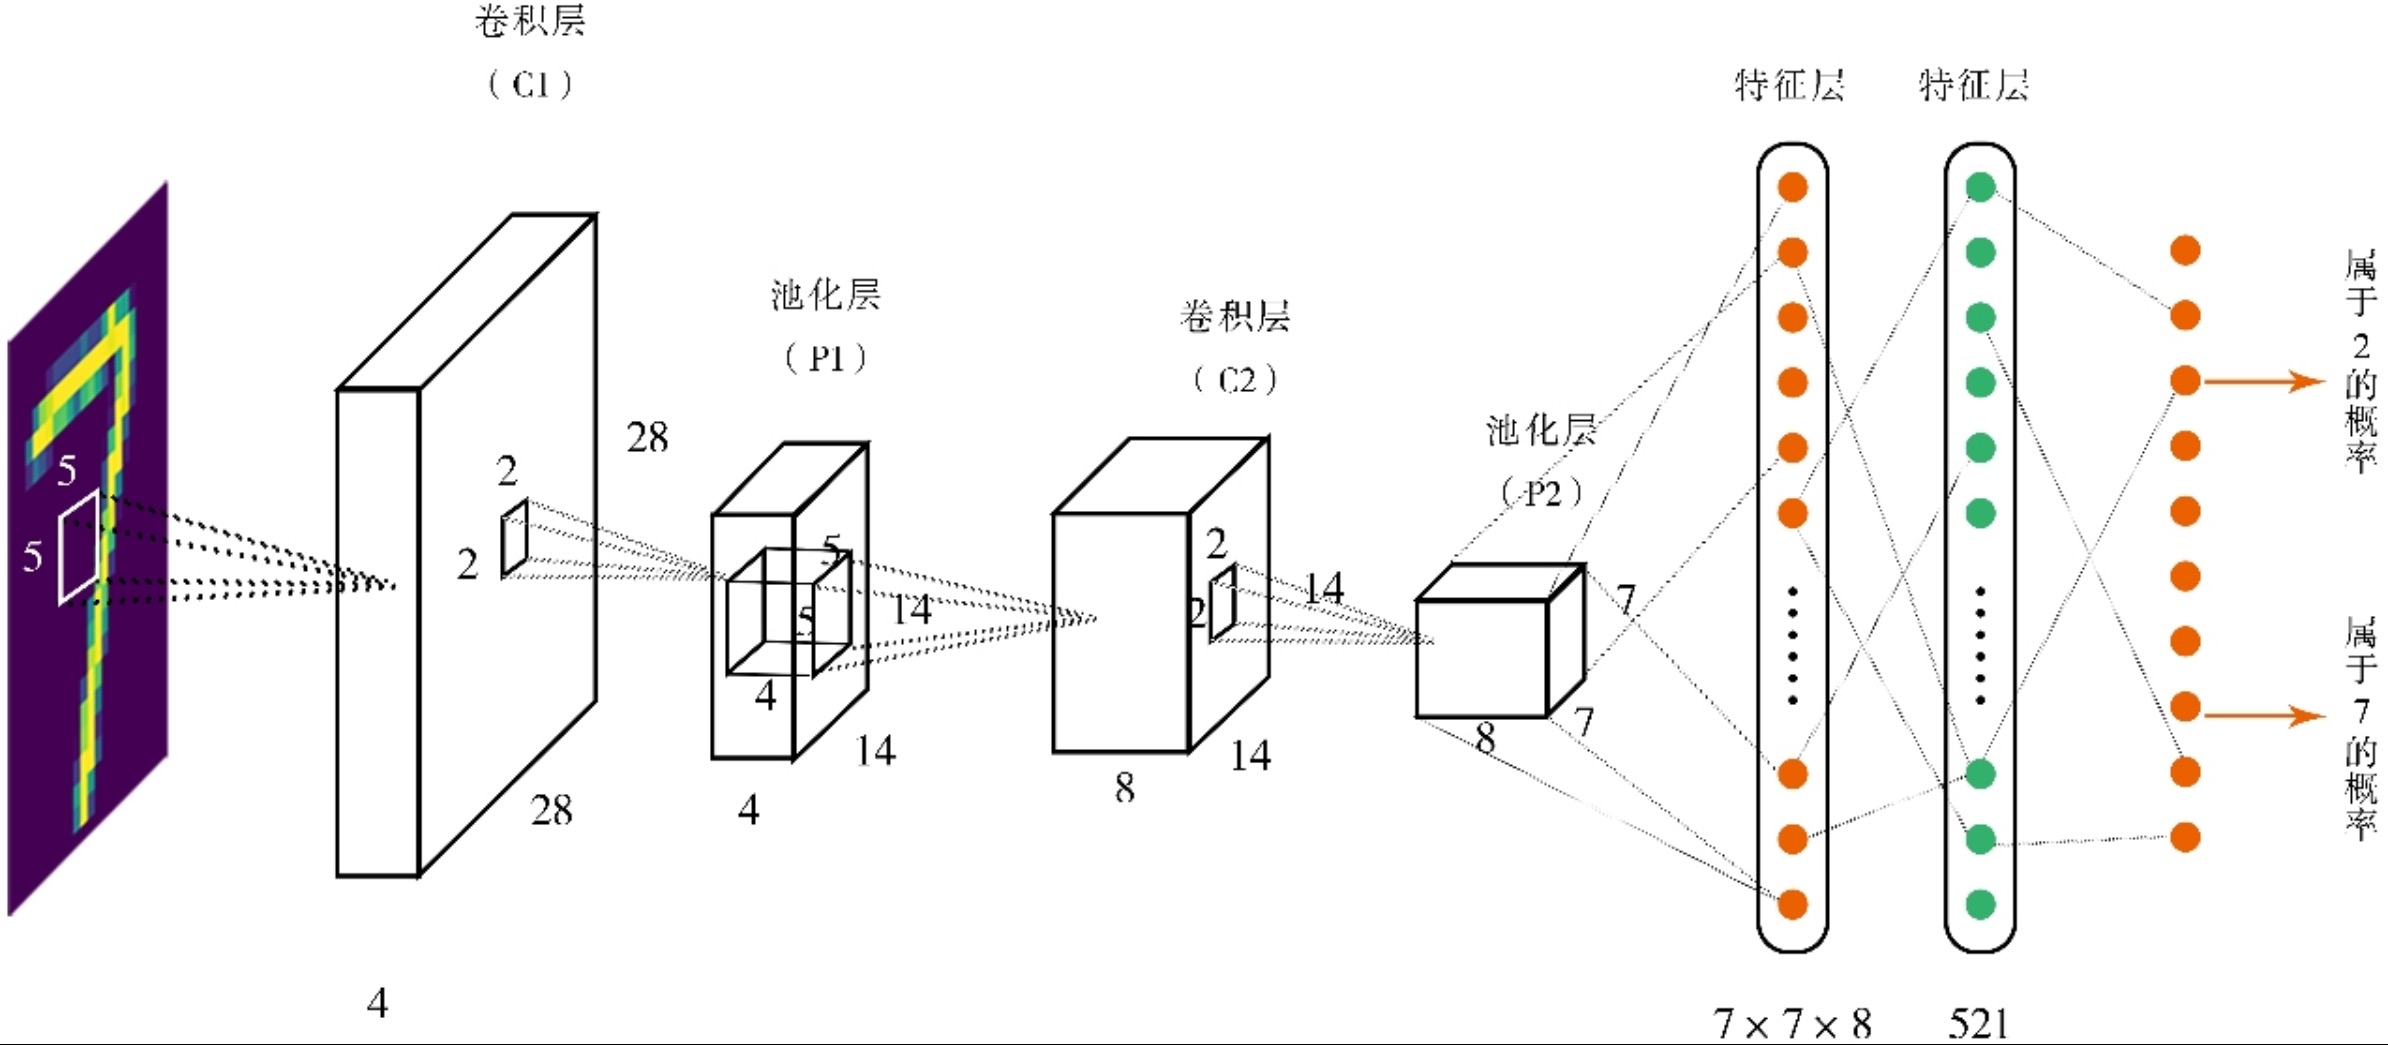

In [ ]:
Image(filename=photo_path3,width=1000,height=500)

整个架构可以分为两大部分，第一部分是由输入图像和4个立方体构成的图像处理部分，其中图像被不断加工成尺寸更小，数量更多的图像；第二部分是由一系列线性排布的神经元构成的普通前馈多层神经网络。

深入看这个卷积神经网络的信息处理过程。首先，输入图像经过一层卷积元素，变成了图中第一个立方体，尺寸为（28,28,4）。实际上，这是4张28X28的图像。之后，这些图像经过池化运算，尺寸缩小了一半，变成了4张14X14的小图，排布成了厚度为4、长宽为14的立方体；之后，这些图形又经历了一次卷积运算，变成了8张图像，尺寸仍然为14X14；最后，这8张图像又经历了一次池化运算，尺寸又变小一半，成为8张7X7的小图片。


**（池化层数据变少，卷积层数据变厚，卷积层变厚的厚度就是卷积核的数量）**

 至此，第一部分的图像运算完成，下面进入第二部分。第二部分的结构和运算过程与基础的分类神经网络没有本质区别。首先，我们**将392(8×7×7)像素的神经元拉伸为一个长度为392的向量**，这些神经元构成了前馈神经网络部分的输入单元，之后经过一层隐含层，再映射到输出单元，**输出10个(0, 1)区间中的小数，表示隶属于0~9这10个数字的概率，且这些数字加起来等于1。**最后，我们再选取最大的数值所对应的数字，作为最后的分类输出。


**所有的卷积、池化运算都是依靠两层之间的神经元连接完成的**，这些连接与普通的前馈神经网络的连接并无本质区别，也对应了一组权重值。我们用这组权重值乘以相应的输入神经元就得到了计算结果。同理，第二部分网络的一层层运算也是由层与层之间的神经元连接完成的，它们也有相应的权重值。

整个卷积神经网络的运作与前两章介绍的神经网络一样，也分成了两个阶段：**前馈运算阶段和反馈学习阶段。**在网络的前馈阶段（从输入图像到输出数字），所有连接的权重值都不改变，系统会根据输入图像计算输出分类，并根据网络的分类与数据中的标签（标准答案）进行比较，**计算出交叉熵作为损失函数**。接下来，在反馈阶段，根据前馈阶段的损失函数调整所有连接上的权重值，从而完成神经网络的学习过程。整个过程与前一章介绍的前馈神经网络类似。



### **1.2 卷积和池化的概念**

举个例子，假设卷积神经网络接收的原始输入图片是下面的左图，它由一系列包含灰度信息的像素构成。与此同时，卷积神经网络的一次卷积运算需要相应的卷积核。卷积运算就是在原始图像中搜索与卷积核相似的区域，即用卷积核从左到右、从上到下地进行逐个像素的扫描和匹配，并最终将匹配结果表示成一个新的图像，即特征图。

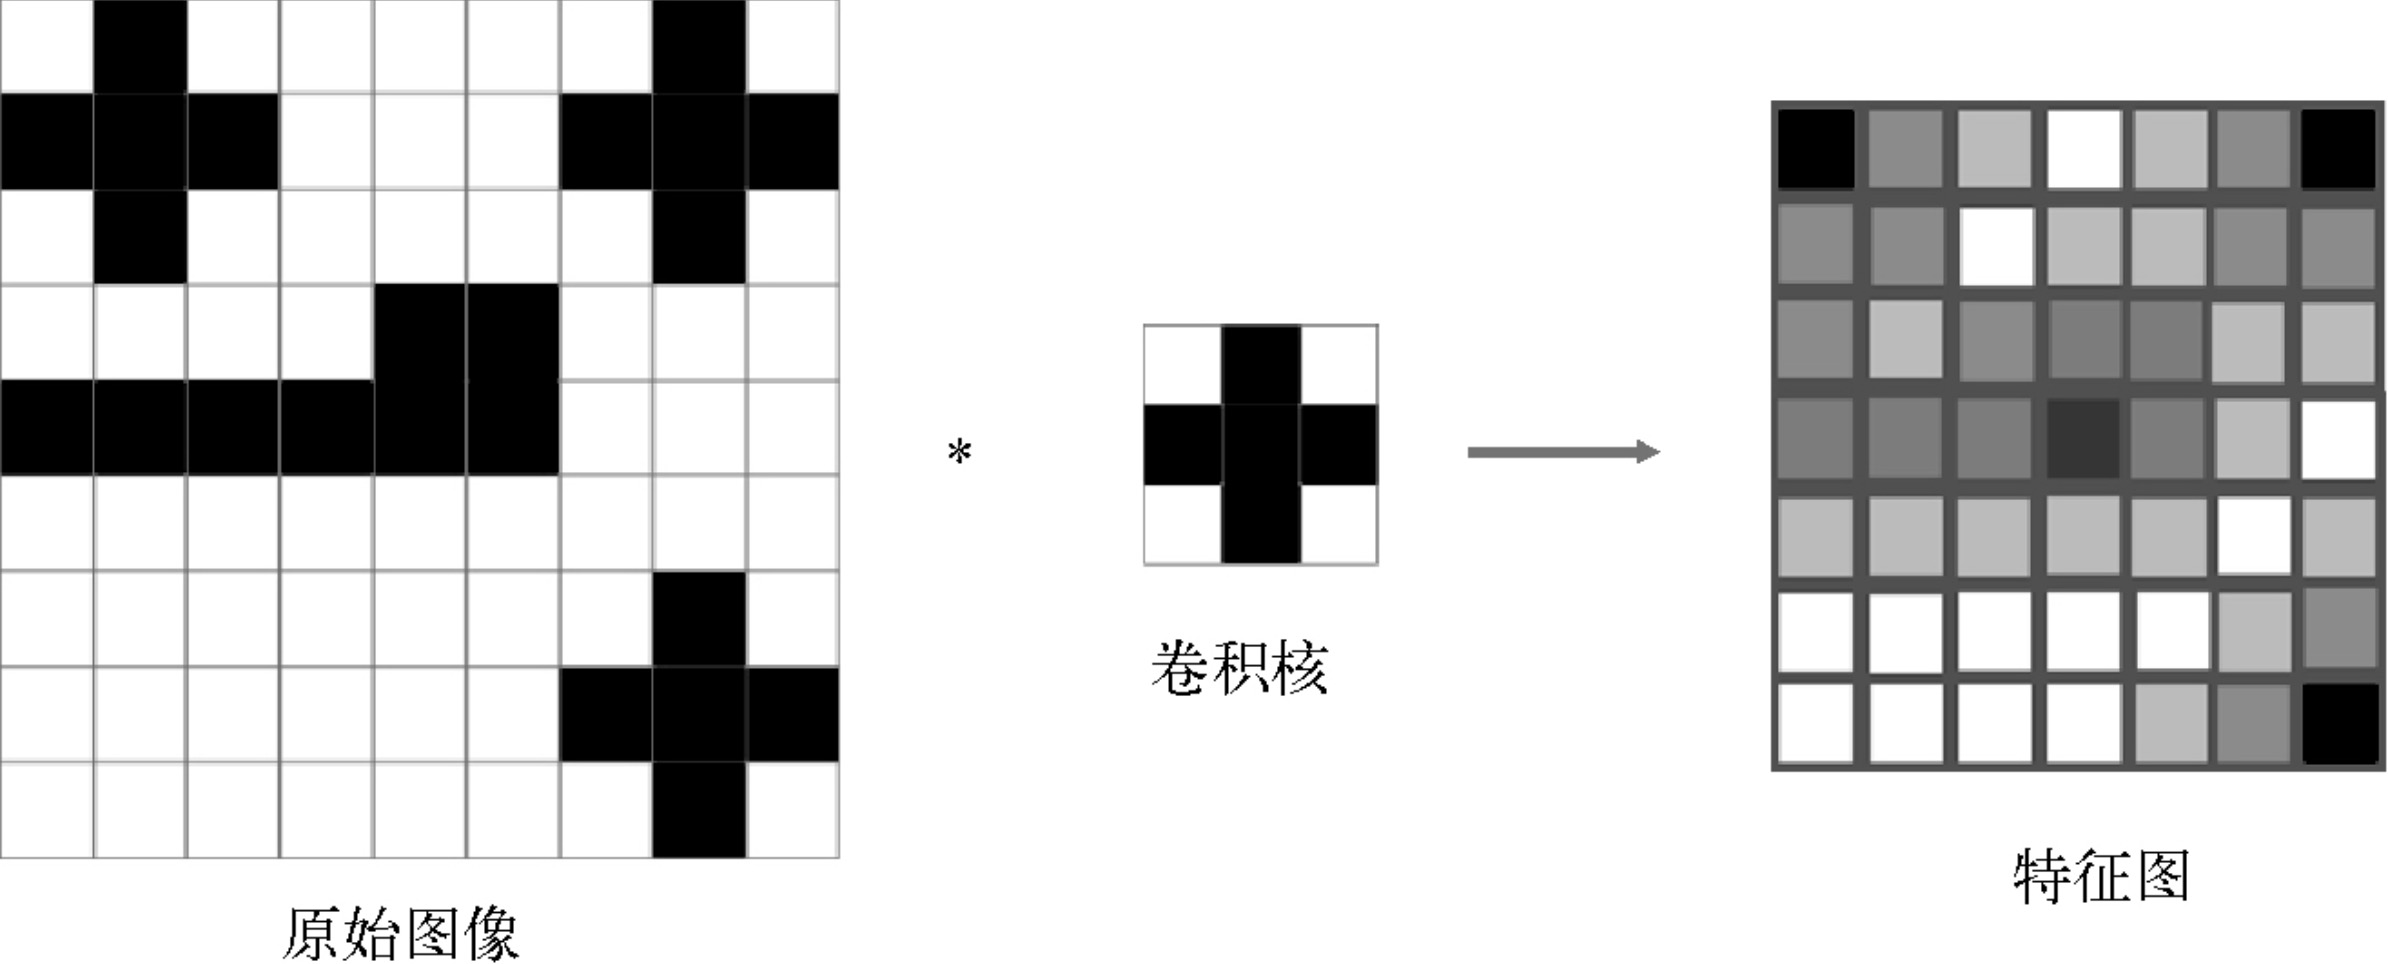

In [ ]:
Image(filename=photo_path4,width=900,height=350)

特征图上有灰有白，每个像素灰度的高低代表了模板与原始图像相应位置的匹配程度，相似程度越高，就越白。


在数学，图像要先数值化，变成矩阵，其中数值是0-255的整数；其次，将卷积核数值化看成是一张3X3的小图，每个像素都是一个实数值对应卷积神经网络的权重。

卷积运算是一个多步的过程。第一步，卷积核与原始图像左上角第一片3X3的区域做内积，将对应位置相乘数字相加，结果就会输出为特征图左上角第一个像素。

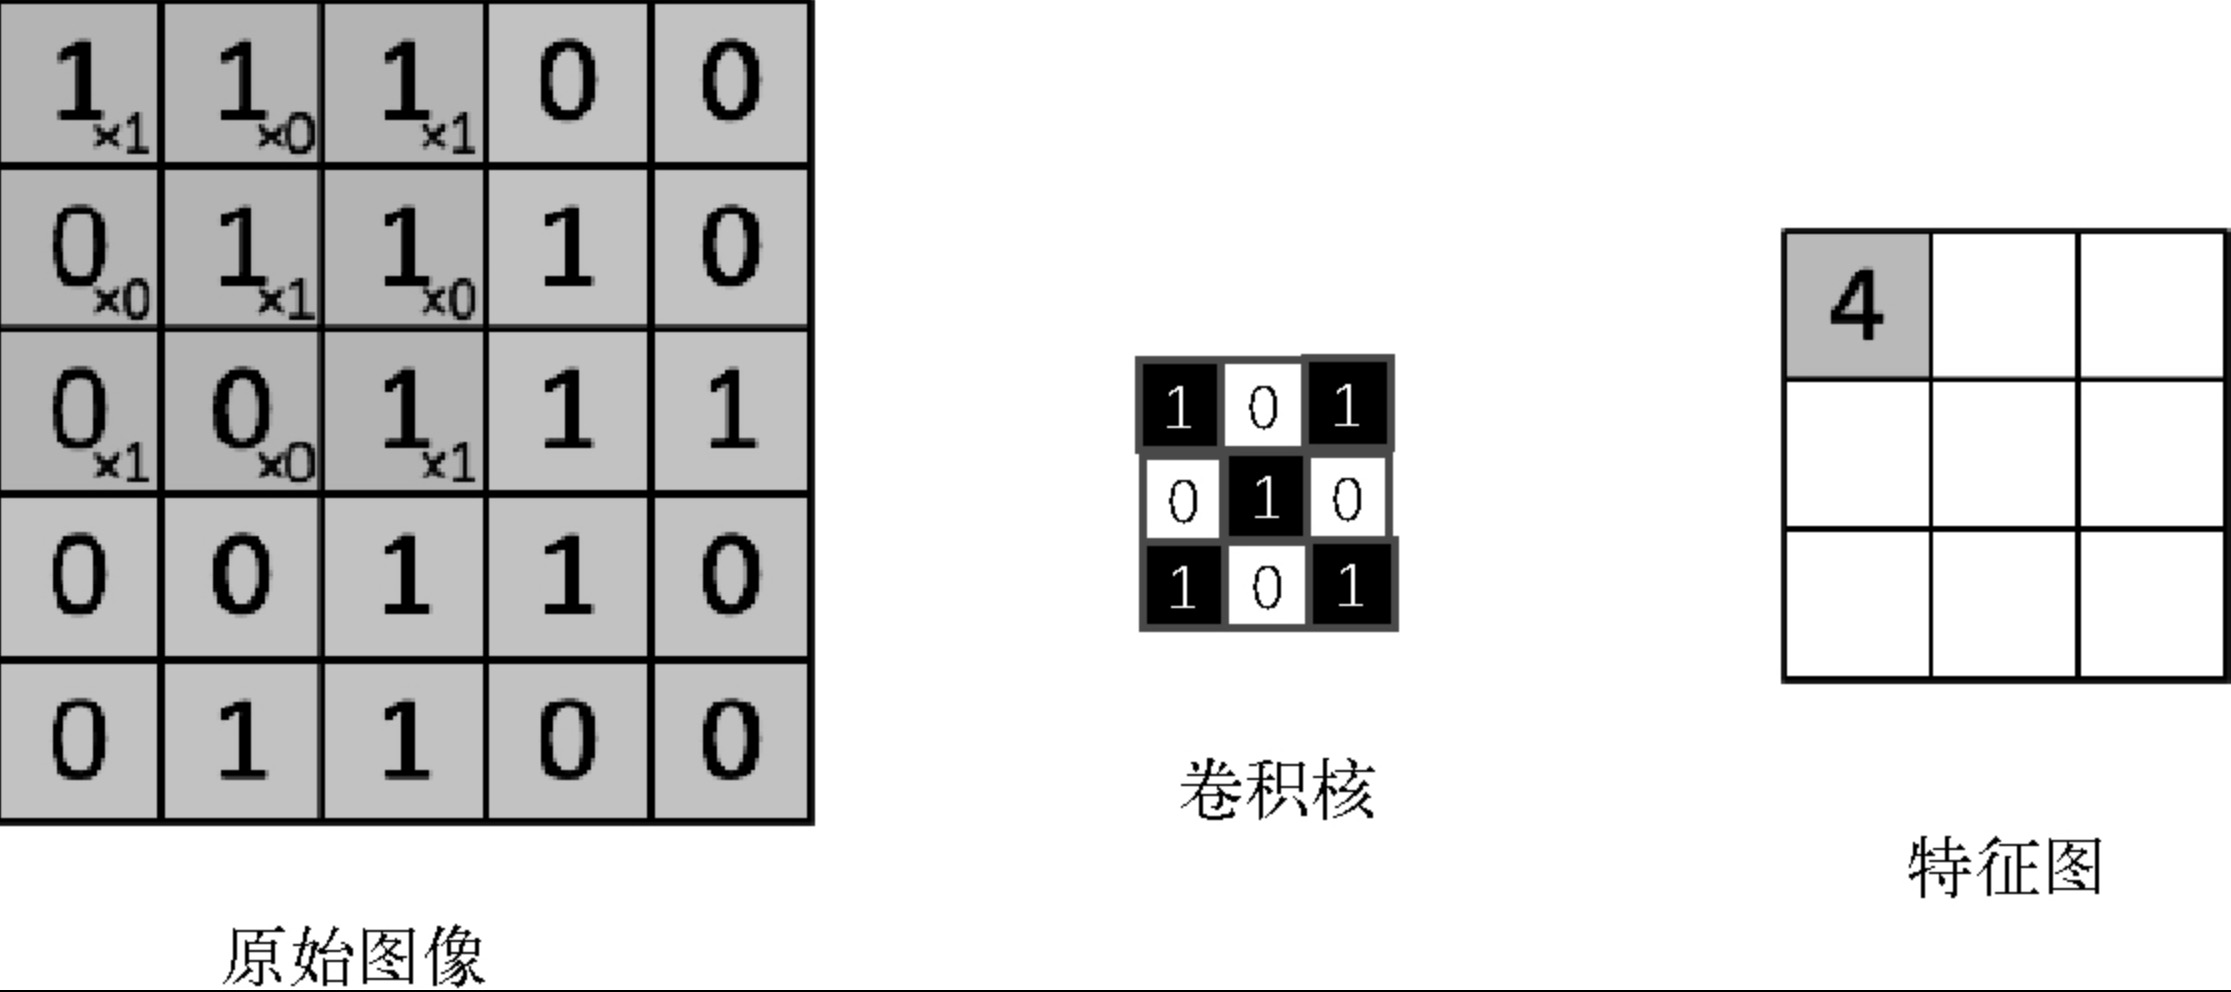

In [ ]:
Image(filename=photo_path5,width=900,height=350)

接着就是左上角第二片的区域做内积，依次类推，最终得到所有特征图的像素，覆盖了原始图像，那么这过程计算就完成了。

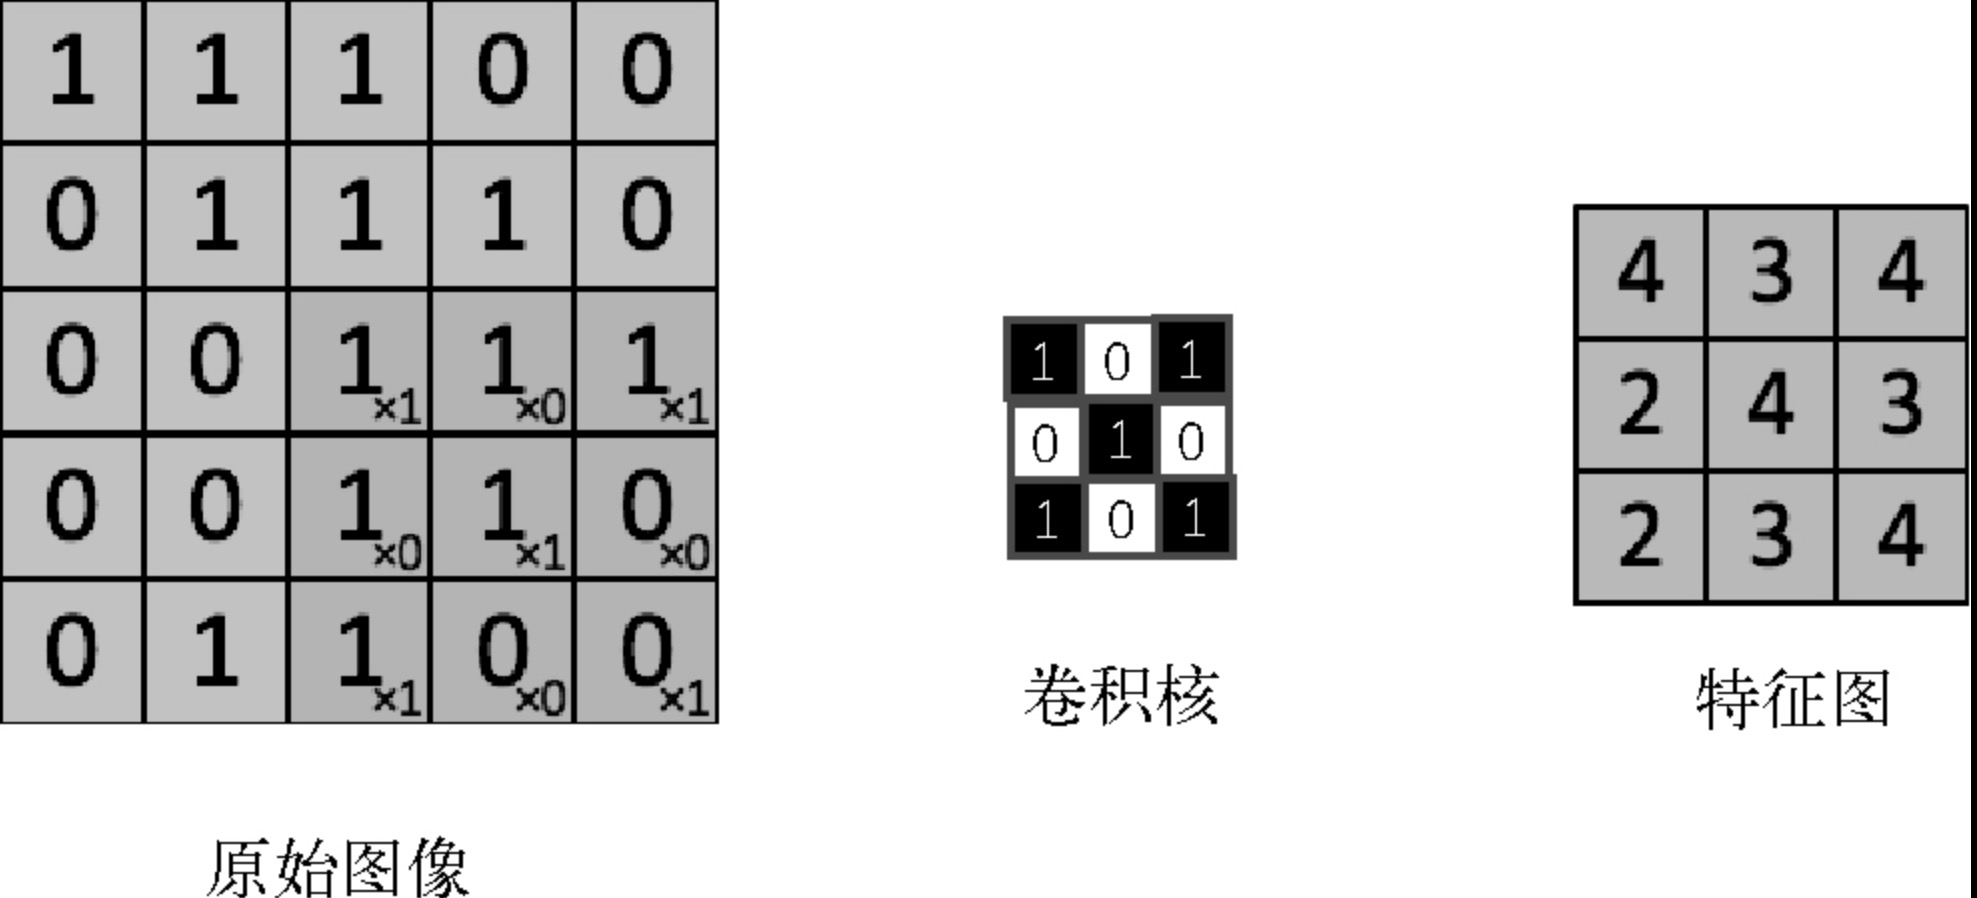

In [ ]:
Image(filename=photo_path6,width=900,height=350)

假设原始图的尺寸是 $n$ ，卷积核的宽度是 $w$ ，特征图的大小一般是 $(n-w+1)(n-w+1)$ ,所以特征图会比原始图像小一点。 **如果不想让特征图变小，那么就需要采用补齐（padding）技术将原始图扩大，并用0来填充补充的区域。**

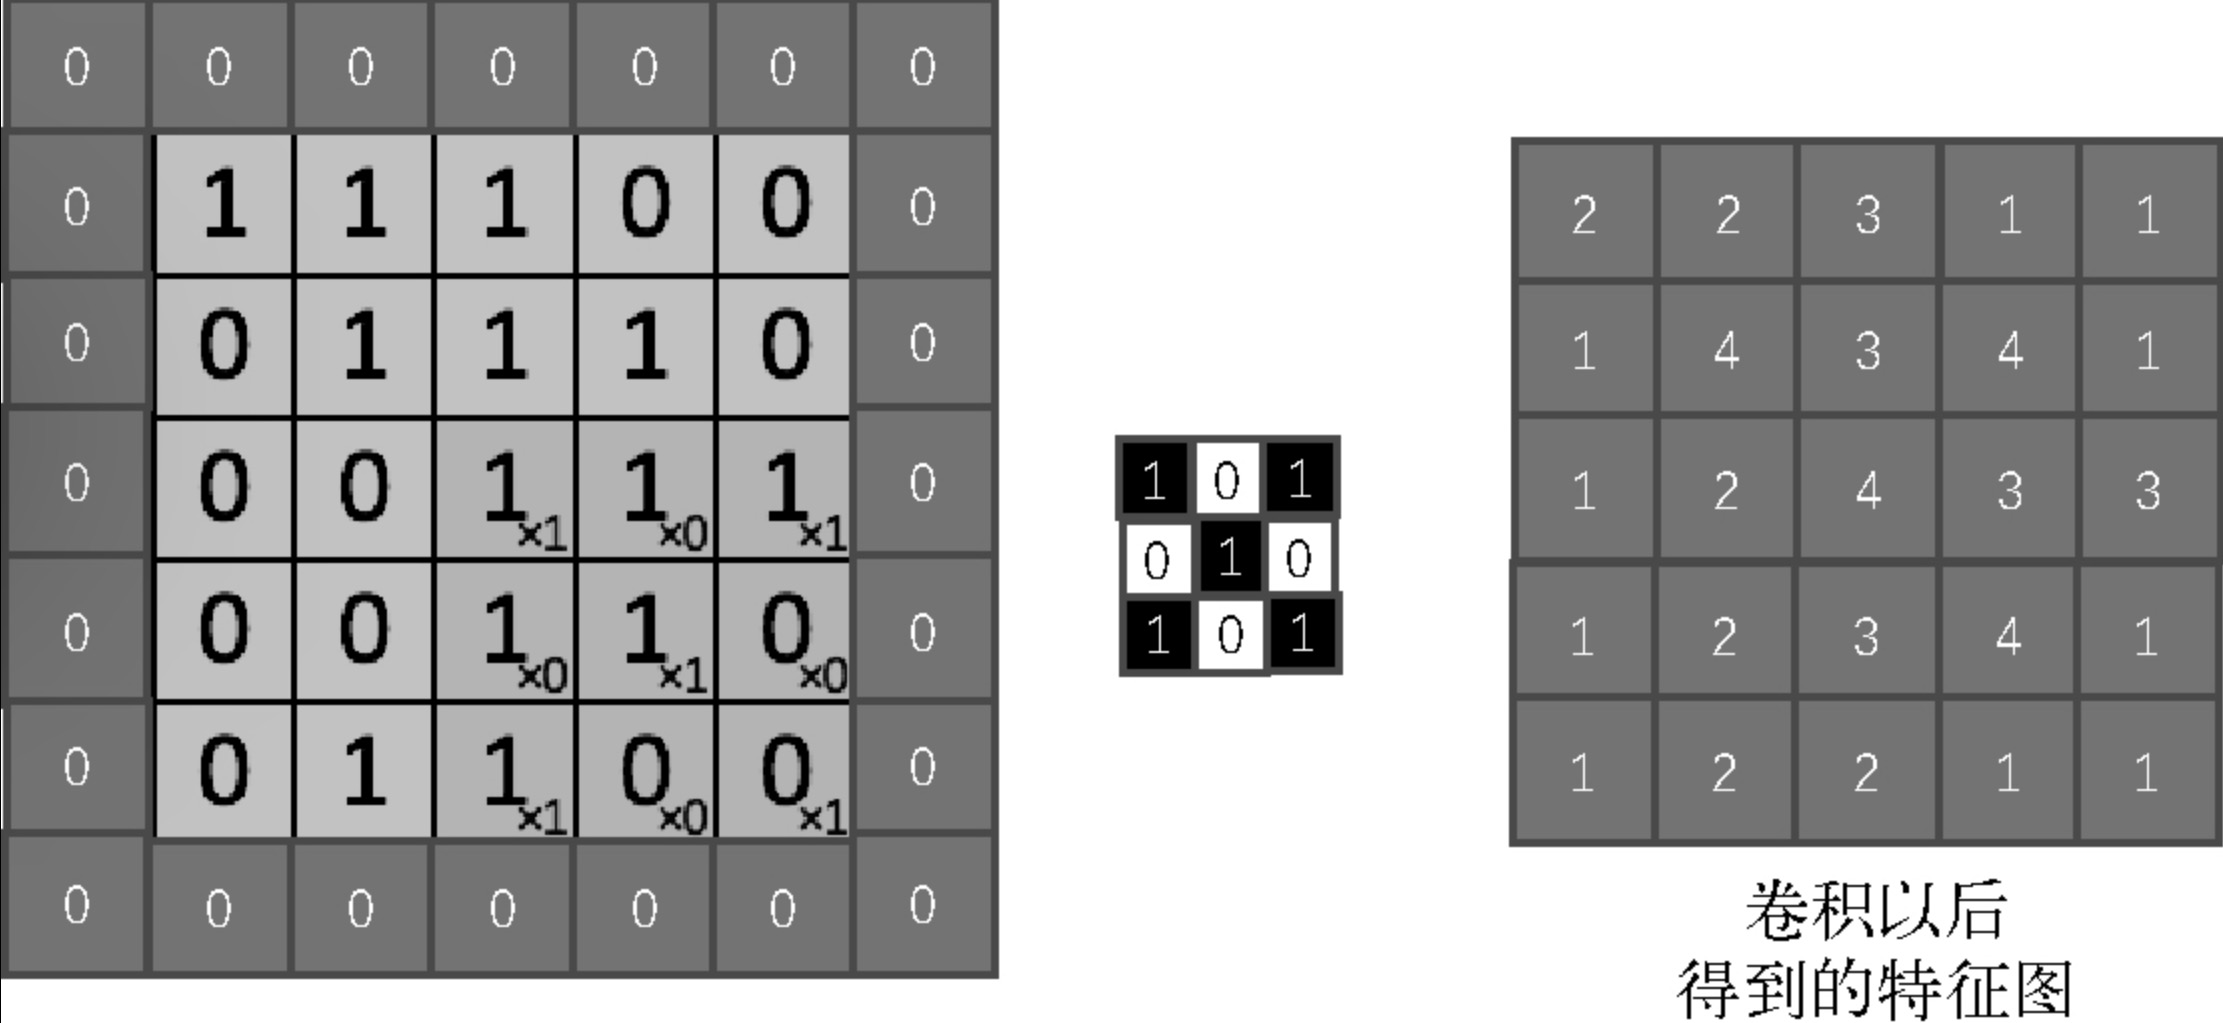

In [ ]:
Image(filename=photo_path7,width=900,height=350)

对于同一张原始输入图像，可以用不同的卷积核与其相作用，每个卷积核相当于不同的模板，每一个卷积核在原始图像的运算结果都能得到不同的特征图。

从神经网络的角度看，特征图上每一个像素（神经元）都和原图上3X3大小的一个方形区域的像素相连（即9个连接），每条连边对应卷积核小矩阵的一个单元，数的大小对应连边上的数字，称为权重值。该权重值可以学习和调节。

一层卷积可能有多个卷积核，用不同颜色表示。

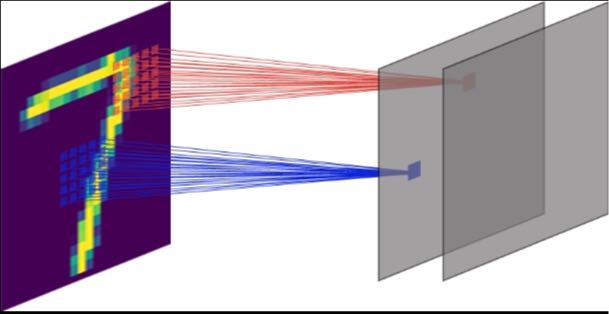

In [ ]:
Image(filename=photo_path8,width=900,height=400)

我们可以将多个特征图拼在一起组成立方体，从而表示多个特征图。 **因此，立方体的厚度是多少，就有多少特征图，也就有多少个卷积核。** 下图是一个厚度为100的特征图，即100个125X125的特征图，有100个卷积核。

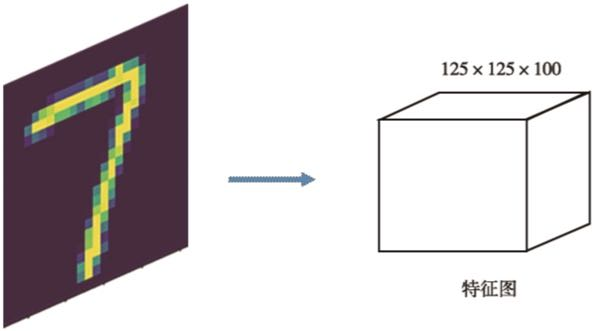

In [ ]:
Image(filename=photo_path9,width=900,height=500)